In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)

# Model parameters
INPUT_DIM = 3
MODEL_DIM = 128
NUM_HEADS = 8
NUM_LAYERS = 4
OUTPUT_DIM = 5
LEARNING_RATE = 0.0001
EPOCHS = 50
BATCH_SIZE = 1024


def load_data_from_text(file_path):
    with open(file_path, 'r') as file:
        content = file.read()

    sequences = content.strip().split('EOT')[:-1]
    inputs = []
    targets = []

    for seq in sequences:
        lines = seq.strip().split('\n')
        target_line = lines[0]
        input_lines = lines[1:]

        target = np.array(list(map(float, target_line.split(','))), dtype=np.float32)
        input_points = np.array([list(map(float, line.split(','))) for line in input_lines], dtype=np.float32)

        targets.append(target)
        inputs.append(input_points)

    return np.stack(inputs), np.stack(targets)

class TrajectoryDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = torch.tensor(inputs, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, output_dim):
        super(TransformerModel, self).__init__()
        self.input_projection = nn.Linear(input_dim, model_dim)
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dim_feedforward=model_dim * 4,
            dropout=0.1,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)
        self.output_projection = nn.Linear(model_dim, output_dim)

    def forward(self, x):
        x = self.input_projection(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        output = self.output_projection(x)
        return output

In [2]:
data_file_path = 'tracks_1m_20_2pi.txt'
inputs, targets = load_data_from_text(data_file_path)

train_inputs, val_inputs, train_targets, val_targets = train_test_split(inputs, targets, test_size=0.2, random_state=SEED)
train_dataset = TrajectoryDataset(train_inputs, train_targets)
val_dataset = TrajectoryDataset(val_inputs, val_targets)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerModel(INPUT_DIM, MODEL_DIM, NUM_HEADS, NUM_LAYERS, OUTPUT_DIM)
if torch.cuda.is_available() and torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model = model.cuda()

model.load_state_dict(torch.load('model_state_dict_1m_20_2pi.pth'))
model.eval()

DataParallel(
  (module): TransformerModel(
    (input_projection): Linear(in_features=3, out_features=128, bias=True)
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (output_projection): Linear(in_features=128, out_features=5, bias=True)
  )
)

In [4]:
import plotly.graph_objects as go

LINE_WIDTH = 2.0

def track(phi, d0, phi0, pt, dz, tanl):
    alpha = 1 / 2  # 1/cB, magnetic field and charge effect factor
    q = 1  # charge of the particle
    kappa = q / pt
    rho = alpha / kappa
    x = d0 * np.cos(phi0) + rho * (np.cos(phi0) - np.cos(phi0 + phi))
    y = d0 * np.sin(phi0) + rho * (np.sin(phi0) - np.sin(phi0 + phi))
    z = dz - rho * tanl * phi
    return x, y, z

def plot_helix_interactive(target, output, distinct_points=None):
    phi = np.linspace(0, 4 * np.pi, 1000)
    target_x, target_y, target_z = track(phi, *target)
    output_x, output_y, output_z = track(phi, *output)

    fig = go.Figure(data=[go.Scatter3d(x=target_x, y=target_y, z=target_z,
                                    #    marker=dict(size=4, color=target_z), # Viridis
                                       mode='lines',
                                       line=dict(color='red', width=LINE_WIDTH),
                                       name='Target_Path')
                         ])
    
    fig.add_trace(go.Scatter3d(x=output_x, y=output_y, z=output_z,
                                    #    marker=dict(size=4, color=output_z),
                                       mode='lines',
                                       line=dict(color='black', width=LINE_WIDTH),
                                       name='Output_Path'
                         ))
    
    if distinct_points is not None:
        fig.add_trace(go.Scatter3d(x=distinct_points[:, 0], y=distinct_points[:, 1], z=distinct_points[:, 2],
                                   mode='markers',
                                   marker=dict(size=3, color='blue')))

    fig.update_layout(title='Interactive 3D Helix',
                      scene=dict(xaxis_title='X Axis',
                                 yaxis_title='Y Axis',
                                 zaxis_title='Z Axis'),
                      margin=dict(l=0, r=0, b=0, t=0))  # Tight layout
    fig.show()

In [22]:
import matplotlib.pyplot as plt

LINE_WIDTH = 0.5

def plot_helix_static(target, output, distinct_points=None, view_angle=None):
    phi = np.linspace(0, 4 * np.pi, 1000)
    target_x, target_y, target_z = track(phi, *target)
    output_x, output_y, output_z = track(phi, *output)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Plotting target path
    ax.plot(target_x, target_y, target_z, label='Target Path', color='red', linewidth=LINE_WIDTH)
    
    # Plotting output path
    ax.plot(output_x, output_y, output_z, label='Output Path', color='black', linewidth=LINE_WIDTH)
    
    # Plotting distinct points if available
    if distinct_points is not None:
        ax.scatter(distinct_points[:, 0], distinct_points[:, 1], distinct_points[:, 2], color='blue', s=10)

    ax.legend()
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    plt.title('Helix Visualization')

    # Setting the view angle
    if view_angle == 'top':
        ax.view_init(elev=90, azim=90)  # Top view
    elif view_angle == 'side':
        ax.view_init(elev=0, azim=0)  # Side view

    plt.show()

tensor([[ -71.7600,  -11.7500,  -27.2100],
        [ -84.7600,  -46.1000,  -39.5500],
        [ -71.1800,  -11.0600,  -26.9000],
        [ -46.0500,    5.5300,  -16.8200],
        [ -57.7400,    0.2300,  -21.0600],
        [ -46.0200,    5.5300,  -16.8100],
        [ -79.0200,  -22.8700,  -31.5800],
        [ -65.3500,   -5.2500,  -24.1700],
        [ -35.4100, -102.8500,  -66.8800],
        [ -74.1800,  -80.1900,  -51.5900],
        [  14.6700,  -13.0000, -110.1900],
        [  12.6000,  -84.5100,  -84.5100],
        [ -82.0300,  -64.7900,  -45.8300],
        [ -51.1000,    3.6300,  -18.5900],
        [ -71.7400,  -83.3500,  -52.9200],
        [ -20.3200,    7.4900,   -8.2000],
        [ -35.4900, -102.8500,  -66.8300],
        [ -50.8500,  -98.7900,  -61.5500],
        [  -6.9900,    3.6400,   -3.6100],
        [ -46.6100, -100.3900,  -63.0600]])
Target: tensor([  0.0000,   4.1600, 111.4100,  -1.0000,   0.3300])
Output: tensor([-5.3088e-03,  4.1004e+00,  1.0497e+02, -5.0962e-02,  3.3

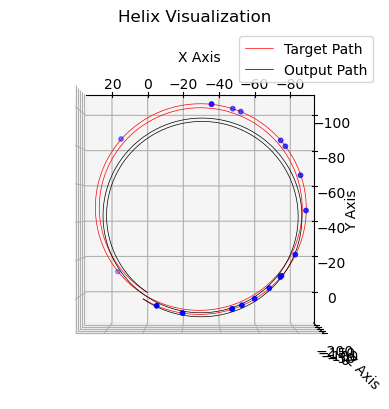

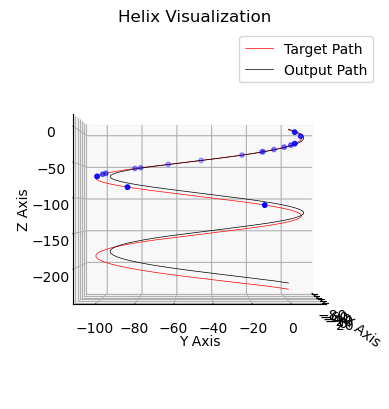

In [55]:
test_input = None
test_target = None
test_output = None
temp_device = 'cpu'

INDEX = 6

with torch.no_grad():
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        # test_input = inputs[INDEX].to(temp_device)
        # test_target = targets[INDEX].to(temp_device)
        # test_output = outputs[INDEX].to(temp_device)
        break

print(test_input)
print(f'Target: {test_target}')
print(f'Output: {test_output}')
# plot_helix_interactive(test_target, test_output, test_input)

# Plot top view
# test_output[1] -= 0.25
plot_helix_static(test_target, test_output, test_input, view_angle='top')

# Plot side view
plot_helix_static(test_target, test_output, test_input, view_angle='side')

In [45]:
all_percentage_differences = []

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        targets += 1e-8
        # test_target = targets[INDEX].to(temp_device)
        # test_output = outputs[INDEX].to(temp_device)
        for target in targets:
            if 0 not in target:
                percentage_differences = 100 * torch.abs((outputs - targets) / targets)
                all_percentage_differences.append(percentage_differences)
        # print(all_percentage_differences[0].shape)
        # break

all_percentage_differences = torch.cat(all_percentage_differences, dim=0)
mean_percentage_differences = torch.mean(all_percentage_differences, dim=0)
print("Mean Percentage Differences for Each Parameter:", mean_percentage_differences)

Mean Percentage Differences for Each Parameter: tensor([2.9644e+07, 2.4024e+07, 4.7181e+00, 1.3371e+06, 3.0433e+06],
       device='cuda:0')


In [7]:
import numpy as np

In [10]:
test = np.array([[[-0.82,  0.55, -0.22],
 [-1.66,  1.13, -0.13],
 [-2.51,  1.66, -0.02],
 [-3.35,  2.18, 0.07],
 [-4.22,  2.68,  0.17],
 [-5.08,  3.19,  0.26],
 [-5.95,  3.67,  0.37],
 [-6.83,  4.16,  0.47],
 [-7.72,  4.61,  0.57],
 [-8.62,  5.05,  0.67]]])

In [26]:
for t in test[:, :, 0]:
    print(t)

[-0.82 -1.66 -2.51 -3.35 -4.22 -5.08 -5.95 -6.83 -7.72 -8.62]


In [33]:
test = np.array([[1, 2, 3], [4, 5, 6]])
print(test.shape)
# print(test[0])
# for t in test:
#     print(t)
def qwe(x, y, z):
    print(x)

qwe(*test)

(2, 3)


TypeError: qwe() missing 1 required positional argument: 'z'